## Elliptical results

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import supervise, autoencode, simulate, simulate_or_load, make_key
from localization.utils import ipr, plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT
from scipy.special import erf
from tqdm import tqdm
import itertools

In [23]:
data_config = dict(
  # Data
  key=jax.random.PRNGKey(0),
  num_dimensions=40,#100, 
  dim=1,
  xi=(1, 3,),
  adjust=(-1.0, 1.0),
  class_proportion=0.5,
)

config = dict(
  # Model
  num_hiddens=1,
  init_scale=0.001,
  activation='relu',
  model_cls=models.SimpleNet,
  use_bias=False, bias_trainable=False, bias_value=0.0,
  optimizer_fn=optax.sgd, 
  learning_rate=0.05,
  num_steps=5000, num_epochs=5000,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  loss_fn='mse',
  save_=True,
  evaluation_interval=100,
  # Misc
  supervise=True,
  wandb_=False, 
)
config.update(data_config)
config.pop('key')

Array([0, 0], dtype=uint32)

### Weird

EllipticalDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_p=0.50_batch_size=10000_num_epochs=5000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init_seed=42
EllipticalDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_p=0.50_batch_size=10000_num_epochs=5000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init
File EllipticalDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_p=0.50_batch_size=10000_num_epochs=5000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init.npz not found
Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'adjust': (-1.0, 1.0),
 'base_dataset': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'batch_size': 10000,
 'bias_trainable': False,
 'bias_value': 0.0,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.elliptical.EllipticalDataset'>,
 'df': None,
 'dim': 1,
 'evaluation_interval': 1

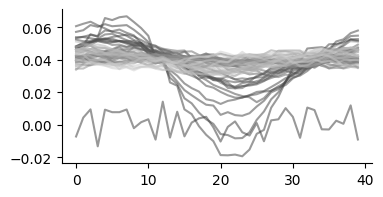

In [24]:
weights_weird, metrics = simulate_or_load(seed=42, dataset_cls=datasets.EllipticalDataset, inverse_cdf=lambda x: -0.5 * jnp.log(2/(x+1) - 1) + 2, batch_size=10000, **config)
fig, ax = plot_rf_evolution(weights_weird[:,[0],:], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig4/rf_evol/weird.pdf', bbox_inches='tight')

### Student-t

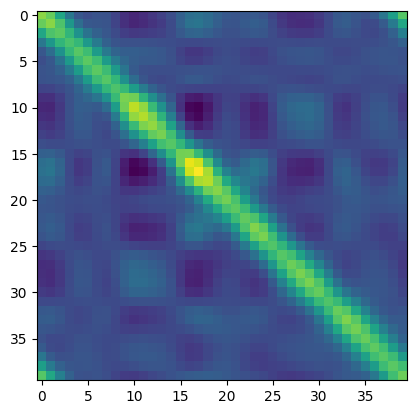

In [28]:
# Covariance nonsense
dataset = datasets.TDataset(df=3, **data_config)
x_t, y = dataset[:100000]
cov_t = jnp.cov(x_t[y==1].T)
_ = plt.imshow(cov_t)
hist_t, bins_t = np.histogram(x_t, bins=100, density=False)
hist_t = hist_t / hist_t.sum()

TDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_df=3_p=0.50_batch_size=1000_num_epochs=10000_loss=mse_lr=0.010_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=1.000_xavier_normal_init_seed=0
TDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_df=3_p=0.50_batch_size=1000_num_epochs=10000_loss=mse_lr=0.010_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=1.000_xavier_normal_init
File TDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_df=3_p=0.50_batch_size=1000_num_epochs=10000_loss=mse_lr=0.010_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=1.000_xavier_normal_init.npz not found
Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'adjust': (-1.0, 1.0),
 'base_dataset': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'batch_size': 1000,
 'bias_trainable': False,
 'bias_value': 0.0,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.multi_t.TDataset'>,
 'df': 3,
 'dim': 1,
 'evaluation_interval': 100,
 'gain': None,
 'init_fn'

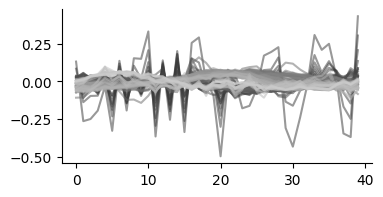

In [30]:
# weights_t, metrics = simulate_or_load(seed=0, dataset_cls=datasets.TDataset, df=3, batch_size=10000, **config)
config_ = config.copy(); config_.pop('learning_rate'); config_.pop('num_steps'); config_.pop('num_epochs'); config_.pop('xi'); config_.pop('num_dimensions'); config_.pop('init_scale')
weights_t, metrics = simulate_or_load(seed=0, dataset_cls=datasets.TDataset, df=3, batch_size=1000, xi=(1, 3,), num_dimensions=40,
                                    #   learning_rate=0.01, num_steps=50000, num_epochs=50000, init_scale=0.01, **config_)
                                    learning_rate=0.01, num_steps=10000, num_epochs=10000, init_scale=1, **config_)
# lr=0.01, steps=10000, init_scale=1. works!!
fig, ax = plot_rf_evolution(weights_t[:,[0],:], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig4/rf_evol_40/t3.pdf', bbox_inches='tight')

### Shell

In [25]:
dataset = datasets.EllipticalDataset(inverse_cdf=lambda x: 1., **data_config)
x_spherical, y = dataset[:100000]
cov_spherical = jnp.cov(x_spherical[y==1].T)
# _ = plt.imshow(cov_spherical)
hist_spherical, bins_spherical = np.histogram(x_spherical, bins=100, density=False)
hist_spherical = hist_spherical / hist_spherical.sum()

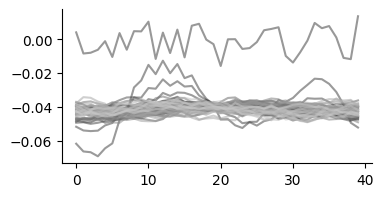

In [27]:
# default for EllipticalDataset: inverse_cdf=lambda x: -0.5 * jnp.log(2/(x+1) - 1) + 2
# weights_shell, metrics = simulate_or_load(seed=0, dataset_cls=datasets.EllipticalDataset, inverse_cdf=lambda x: 1., batch_size=10000, **config)
fig, ax = plot_rf_evolution(weights_shell[:,[0],:], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig4/rf_evol_40/shell.pdf', bbox_inches='tight')

### Plotting

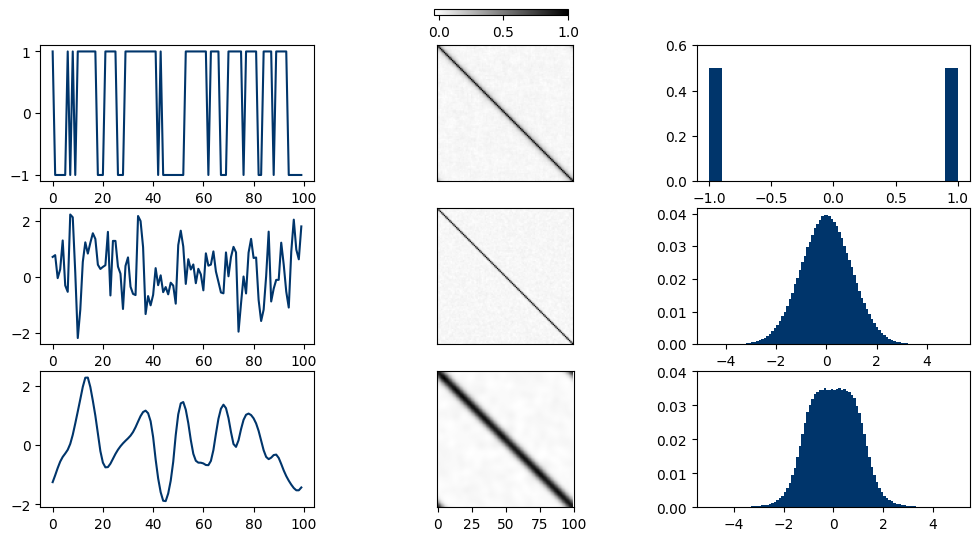

In [102]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6))#, sharex='col')

# Ising
axs[0,0].plot(x_ising[0], color='#00356b')

im = axs[0,1].imshow(cov_ising, cmap='binary')
cbar_ax = fig.add_axes([0.453, 0.93, 0.112, 0.01])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
axs[0,1].set_xticks([]); axs[0,1].set_yticks([])

bin_width = bins_ising[1] - bins_ising[0]  # Calculate the width of each bin
axs[0,2].bar(bins_ising[:-1], hist_ising, width=bin_width, align='edge', color='#00356b')
axs[0,2].set_yticks([0.0, 0.2, 0.4, 0.6])

# Gaussian
axs[1,0].plot(x_gaussian[0], color='#00356b')

im = axs[1,1].imshow(cov_gaussian, cmap='binary')
axs[1,1].set_xticks([]); axs[1,1].set_yticks([])

bin_width = bins_gaussian[1] - bins_gaussian[0]  # Calculate the width of each bin
axs[1,2].bar(bins_gaussian[:-1], hist_gaussian, width=bin_width, align='edge', color='#00356b')
axs[1,2].set_yticks([0.0, 0.01, 0.02, 0.03, 0.04])

# Alg(5)
axs[2,0].plot(x_alg[0], color='#00356b')

axs[2,1].imshow(cov_alg, cmap='binary')
axs[2,1].set_xticks([0, 25, 50, 75, 100]); axs[2,1].set_yticks([])

bin_width = bins_alg[1] - bins_alg[0]  # Calculate the width of each bin
axs[2,2].bar(bins_alg[:-1], hist_alg, width=bin_width, align='edge', color='#00356b')
axs[2,2].set_yticks([0.0, 0.01, 0.02, 0.03, 0.04])

# fig.tight_layout()
fig.savefig('fig2.svg')